# Geometric operations

## Overlay analysis

In this tutorial, the aim is to make an overlay analysis where we create a new layer based on geometries from a dataset that `intersect` with geometries of another layer. As our test case, we will select Polygon grid cells from `TravelTimes_to_5975375_RailwayStation_Helsinki.shp` that intersects with municipality borders of Helsinki found in `Helsinki_borders.shp`.

Typical overlay operations are (source: [QGIS docs](https://docs.qgis.org/2.8/en/docs/gentle_gis_introduction/vector_spatial_analysis_buffers.html#more-spatial-analysis-tools)):
![](img/overlay_operations.png)

## Download data

For this lesson, you should [download a data package](https://github.com/AutoGIS/data/raw/master/L4_data.zip) that includes 3 files:

 1. Helsinki_borders.shp
 2. Travel_times_to_5975375_RailwayStation.shp
 3. Amazon_river.shp
 
```
$ cd /home/jovyan/notebooks/L4
$ wget https://github.com/AutoGIS/data/raw/master/L4_data.zip
$ unzip L4_data.zip
```

Let's first read the data and see how they look like.

- Import required packages and read in the input data:

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.speedups
%matplotlib inline

# File paths
border_fp = "data/Helsinki_borders.shp"
grid_fp = "data/TravelTimes_to_5975375_RailwayStation.shp"

# Read files
grid = gpd.read_file(grid_fp)
hel = gpd.read_file(border_fp)

- Visualize the layers:

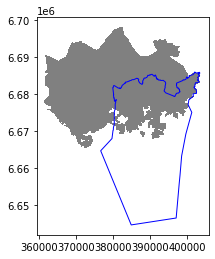

In [2]:
# Plot the layers
ax = grid.plot(facecolor='gray')
hel.plot(ax=ax, facecolor='None', edgecolor='blue')

Here the grey area is the Travel Time Matrix grid (13231 grid squares) that covers the Helsinki region, and the blue area represents the municipality of Helsinki. Our goal is to conduct an overlay analysis and select the geometries from the grid polygon layer that intersect with the Helsinki municipality polygon.

When conducting overlay analysis, it is important to check that the CRS of the layers match!

- Check if Helsinki polygon and the grid polygon are in the same crs:

In [3]:
# Ensure that the CRS matches, if not raise an AssertionError
assert hel.crs == grid.crs, "CRS differs between layers!"

Indeed, they do. Hence, the pre-requisite to conduct spatial operations between the layers is fullfilled (also the map we plotted indicated this).

- Let's do an overlay analysis and create a new layer from polygons of the grid that `intersect` with our Helsinki layer. We can use a function called `overlay()` to conduct the overlay analysis that takes as an input 1) the GeoDataFrame where the selection is taken, 2) the GeoDataFrame used for making the selection, and 3) parameter `how` that can be used to control how the overlay analysis is conducted (possible values are `'intersection'`, `'union'`, `'symmetric_difference'`, `'difference'`, and `'identity'`):

In [4]:
intersection = gpd.overlay(grid, hel, how='intersection')

- Let's plot our data and see what we have:

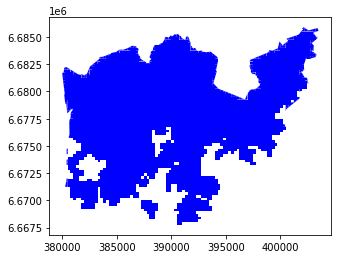

In [5]:
intersection.plot(color="b")

As a result, we now have only those grid cells that intersect with the Helsinki borders. As we can see **the grid cells are clipped based on the boundary.**

- Whatabout the data attributes? Let's see what we have:


In [6]:
print(intersection.head())

   car_m_d  car_m_t  car_r_d  car_r_t  from_id  pt_m_d  pt_m_t  pt_m_tt  \
0    29476       41    29483       46  5876274   29990      76       95   
1    29456       41    29462       46  5876275   29866      74       95   
2    36772       50    36778       56  5876278   33541     116      137   
3    36898       49    36904       56  5876279   33720     119      141   
4    29411       40    29418       44  5878128   29944      75       95   

   pt_r_d  pt_r_t  pt_r_tt    to_id  walk_d  walk_t    GML_ID   NAMEFIN  \
0   24984      77       99  5975375   25532     365  27517366  Helsinki   
1   24860      75       93  5975375   25408     363  27517366  Helsinki   
2   44265     130      146  5975375   31110     444  27517366  Helsinki   
3   44444     132      155  5975375   31289     447  27517366  Helsinki   
4   24938      76       99  5975375   25486     364  27517366  Helsinki   

       NAMESWE NATCODE                                           geometry  
0  Helsingfors     091

As we can see, due to the overlay analysis, the dataset contains the attributes from both input layers.

- Let's save our result grid as a GeoJSON file that is commonly used file format nowadays for storing spatial data.


In [7]:
# Output filepath
outfp = "data/TravelTimes_to_5975375_RailwayStation_Helsinki.geojson"

# Use GeoJSON driver
intersection.to_file(outfp, driver="GeoJSON")

There are many more examples for different types of overlay analysis in [Geopandas documentation](http://geopandas.org/set_operations.html) where you can go and learn more.

## Aggregating data

Data aggregation refers to a process where we combine data into groups. When doing spatial data aggregation, we merge the geometries together into coarser units (based on some attribute), and can also calculate summary statistics for these combined geometries from the original, more detailed values. For example, suppose that we are interested in studying continents, but we only have country-level data like the country dataset. If we aggregate the data by continent, we would convert the country-level data into a continent-level dataset.

In this tutorial, we will aggregate our travel time data by car travel times (column `car_r_t`), i.e. the grid cells that have the same travel time to Railway Station will be merged together.

- For doing the aggregation we will use a function called `dissolve()` that takes as input the column that will be used for conducting the aggregation:


In [8]:
# Conduct the aggregation
dissolved = intersection.dissolve(by="car_r_t")

# What did we get
print(dissolved.head())

                                                  geometry  car_m_d  car_m_t  \
car_r_t                                                                        
-1       MULTIPOLYGON (((388000.000 6668750.000, 387750...       -1       -1   
 0       POLYGON ((386000.000 6672000.000, 385750.000 6...        0        0   
 7       POLYGON ((386250.000 6671750.000, 386000.000 6...     1051        7   
 8       MULTIPOLYGON (((386250.000 6671500.000, 386000...     1286        8   
 9       MULTIPOLYGON (((386500.000 6671250.000, 386250...     1871        9   

         car_r_d  from_id  pt_m_d  pt_m_t  pt_m_tt  pt_r_d  pt_r_t  pt_r_tt  \
car_r_t                                                                       
-1            -1  5913094      -1      -1       -1      -1      -1       -1   
 0             0  5975375       0       0        0       0       0        0   
 7          1051  5973739     617       5        6     617       5        6   
 8          1286  5973736     706      10   

- Let's compare the number of cells in the layers before and after the aggregation:

In [9]:
print('Rows in original intersection GeoDataFrame:', len(intersection))
print('Rows in dissolved layer:', len(dissolved))

Rows in original intersection GeoDataFrame: 3826
Rows in dissolved layer: 51


Indeed the number of rows in our data has decreased and the Polygons were merged together.

What actually happened here? Let's take a closer look. 

- Let's see what columns we have now in our GeoDataFrame:

In [10]:
print(dissolved.columns)

Index(['geometry', 'car_m_d', 'car_m_t', 'car_r_d', 'from_id', 'pt_m_d',
       'pt_m_t', 'pt_m_tt', 'pt_r_d', 'pt_r_t', 'pt_r_tt', 'to_id', 'walk_d',
       'walk_t', 'GML_ID', 'NAMEFIN', 'NAMESWE', 'NATCODE'],
      dtype='object')


As we can see, the column that we used for conducting the aggregation (`car_r_t`) can not be found from the columns list anymore. What happened to it?

- Let's take a look at the indices of our GeoDataFrame:

In [11]:
print(dissolved.index)

Int64Index([-1,  0,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
            22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
            39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
            56],
           dtype='int64', name='car_r_t')


Aha! Well now we understand where our column went. It is now used as index in our `dissolved` GeoDataFrame. 

- Now, we can for example select only such geometries from the layer that are for example exactly 15 minutes away from the Helsinki Railway Station:

In [12]:
# Select only geometries that are within 15 minutes away
dissolved.iloc[15]

geometry    (POLYGON ((388250.0001354316 6668750.000042891...
car_m_d                                                 12035
car_m_t                                                    18
car_r_d                                                 11997
from_id                                               5903886
pt_m_d                                                  11568
pt_m_t                                                     30
pt_m_tt                                                    36
pt_r_d                                                  11568
pt_r_t                                                     34
pt_r_tt                                                    37
to_id                                                 5975375
walk_d                                                  11638
walk_t                                                    166
GML_ID                                               27517366
NAMEFIN                                              Helsinki
NAMESWE 

In [13]:
# See the data type
print(type(dissolved.iloc[15]))

<class 'pandas.core.series.Series'>


In [14]:
# See the data
print(dissolved.iloc[15].head())

geometry    (POLYGON ((388250.0001354316 6668750.000042891...
car_m_d                                                 12035
car_m_t                                                    18
car_r_d                                                 11997
from_id                                               5903886
Name: 20, dtype: object


As we can see, as a result, we have now a Pandas `Series` object containing basically one row from our original aggregated GeoDataFrame.

Let's also visualize those 15 minute grid cells.

- First, we need to convert the selected row back to a GeoDataFrame:

In [15]:
# Create a GeoDataFrame
selection = gpd.GeoDataFrame([dissolved.iloc[15]], crs=dissolved.crs)

- Plot the selection on top of the entire grid:

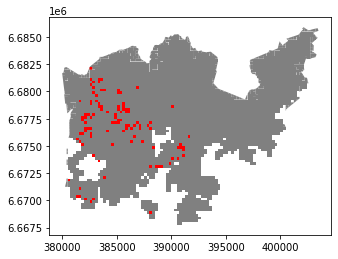

In [16]:
# Plot all the grid cells, and the grid cells that are 15 minutes a way from the Railway Station
ax = dissolved.plot(facecolor='gray')
selection.plot(ax=ax, facecolor='red')

## Simplifying geometries

Sometimes it might be useful to be able to simplify geometries. This could be something to consider for example when you have very detailed spatial features that cover the whole world. If you make a map that covers the whole world, it is unnecessary to have really detailed geometries because it is simply impossible to see those small details from your map. Furthermore, it takes a long time to actually render a large quantity of features into a map. Here, we will see how it is possible to simplify geometric features in Python.

As an example we will use data representing the Amazon river in South America, and simplify it's geometries.

- Let's first read the data and see how the river looks like:

PROJCS["Mercator_2SP",GEOGCS["GCS_GRS 1980(IUGG, 1980)",DATUM["D_unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Unknown",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mercator_2SP"],PARAMETER["standard_parallel_1",-2],PARAMETER["central_meridian",-43],PARAMETER["false_easting",5000000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


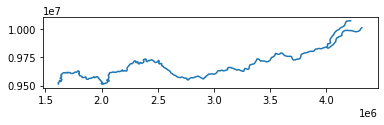

In [25]:
import geopandas as gpd

# File path
fp = "data/Amazon_river.shp"
data = gpd.read_file(fp)

# Print crs
print(data.crs)

# Plot the river
data.plot();

The LineString that is presented here is quite detailed, so let's see how we can generalize them a bit. As we can see from the coordinate reference system, the data is projected in a metric system using [Mercator projection based on SIRGAS datum](http://spatialreference.org/ref/sr-org/7868/). 

- Generalization can be done easily by using a Shapely function called `.simplify()`. The `tolerance` parameter can be used to adjusts how much geometries should be generalized. **The tolerance value is tied to the coordinate system of the geometries**. Hence, the value we pass here is 20 000 **meters** (20 kilometers).



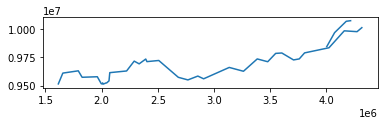

In [26]:
# Generalize geometry
data2 = data.copy()
data2['geom_gen'] = data2.simplify(tolerance=20000)

# Set geometry to be our new simlified geometry
data2 = data2.set_geometry('geom_gen')

# Plot 
data2.plot()

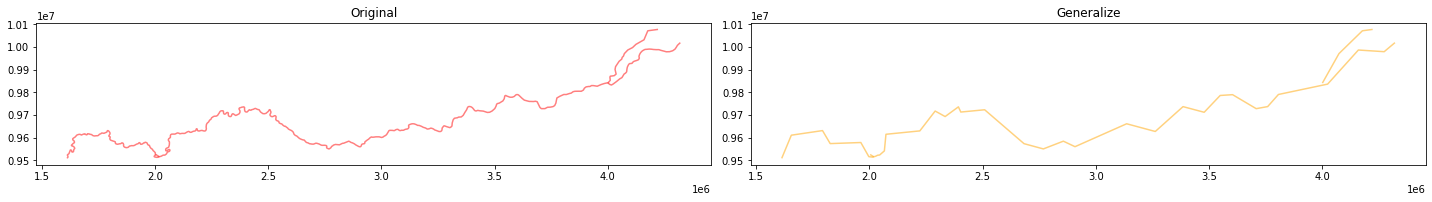

In [27]:
# plot them side-by-side
%matplotlib inline
import matplotlib.pyplot as plt

#basic config
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
#ax1, ax2 = axes

#1st plot
ax1 = data.plot(ax=ax1, color='red', alpha=0.5)
ax1.set_title('Original')

#2nd plot
ax2 = data2.plot(ax=ax2, color='orange', alpha=0.5)
ax2.set_title('Generalize')
# set limit to zoom closer to the area of interest
#ax2.set_xlim([380000, 395000])
#ax2.set_ylim([6667500, 6680000])

fig.tight_layout()

Nice! As a result, now we have simplified our LineString quite significantly as we can see from the map.